<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Setting up Polytropic [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Initial Data, in Curvilinear Coordinates

## Authors: Zach Etienne, Phil Chang, and Leo Werneck
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a TOV star in *spherical, isotropic coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plots](#convergence) at bottom). Note that convergence at the surface of the star will be lower order due to the sharp drop to zero in $T^{\mu\nu}$.</font>

### NRPy+ Source Code for this module: 

* [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py); ([**NRPy+ Tutorial module reviewing mathematical formulation and equations solved**](Tutorial-ADM_Initial_Data-TOV.ipynb)); ([**start-to-finish NRPy+ Tutorial module demonstrating that initial data satisfy Hamiltonian constraint**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb)): Tolman-Oppenheimer-Volkoff (TOV) initial data; defines all ADM variables and nonzero $T^{\mu\nu}$ components in Spherical basis.
* [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

## Introduction:
Here we use NRPy+ to set up initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation).

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration [(**NRPy+ tutorial on NRPy+ Method of Lines algorithm**)](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on TOV initial data**](Tutorial-ADM_Initial_Data-TOV.ipynb)
    * [**NRPy+ tutorial on validating TOV initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb).
1. Evaluate the Hamiltonian constraint violation
    * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence of Hamiltonian constraint violation to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#adm_id_tov): Set up ADM initial data for polytropic TOV Star
    1. [Step 2.a](#tov_interp): Interpolating the TOV data file as needed
    1. [Step 2.b](#source): Compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$
    1. [Step 2.c](#jacobian): Jacobian transformation on the ADM/BSSN source terms
    1. [Step 2.d](#tensor): Rescale tensorial quantities
1. [Step 3](#adm_id_spacetime): Convert ADM spacetime quantity initial data from Spherical to BSSN Curvilinear coordinates
1. [Step 4](#validate): Validating that the TOV initial data satisfy the Hamiltonian constraint
    1. [Step 4.a](#ham_const_output): Output the Hamiltonian Constraint
    1. [Step 4.b](#apply_bcs): Apply singular, curvilinear coordinate boundary conditions
    1. [Step 4.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
1. [Step 5](#mainc): `TOV_Playground.c`: The Main C Code
1. [Step 6](#plot): Plotting the single-neutron-star initial data
1. [Step 7](#convergence): Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero
1. [Step 8](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initalizenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$


In [1]:
# Step 1: Initialize core Python/NRPy+ modules and parameters
# Step 1.a: Add the NRPy+ base directory to the path
import os,sys,shutil            # Standard Python modules for multiplatform OS-level functions
nrpy_dir_path = os.path.join("..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

In [2]:
# Step P1: Import needed NRPy+ core modules:
from outputC import outputC,add_to_Cfunction_dict # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import sympy as sp               # SymPy: The Python computer algebra package upon which NRPy+ depends
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("TOVID_Ccodes_new_way/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step 1: Set the spatial dimension parameter
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size     = 7.5 # SET BELOW BASED ON TOV STELLAR RADIUS

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial finite difference derivatives;
#           and the core data type.
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.

# Step 3: Polytropic EOS setup
# For EOS_type, choose either "SimplePolytrope" or "PiecewisePolytrope"
EOS_type = "SimplePolytrope"
# If "PiecewisePolytrope" is chosen as EOS_type, you
#   must also choose the name of the EOS, which can
#   be any of the following:
# 'PAL6', 'SLy', 'APR1', 'APR2', 'APR3', 'APR4',
# 'FPS', 'WFF1', 'WFF2', 'WFF3', 'BBB2', 'BPAL12',
# 'ENG', 'MPA1', 'MS1', 'MS2', 'MS1b', 'PS', 'GS1',
# 'GS2', 'BGN1H1', 'GNH3', 'H1', 'H2', 'H3', 'H4',
# 'H5', 'H6', 'H7', 'PCL2', 'ALF1', 'ALF2', 'ALF3',
# 'ALF4'
EOS_name = 'SLy' # <-- IGNORED IF EOS_type is not PiecewisePolytrope.

In [3]:
# Step 4: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

<a id='adm_id_tov'></a>

# Step 2: Set up ADM initial data for polytropic TOV Star \[Back to [top](#toc)\]
$$\label{adm_id_tov}$$

As documented [in the TOV Initial Data NRPy+ Tutorial Module](Tutorial-TOV_Initial_Data.ipynb) ([older version here](Tutorial-GRMHD_UnitConversion.ipynb)), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***).

The TOV solver uses an ODE integration routine provided by scipy, so we first make sure that scipy is installed:

In [4]:
!pip install scipy > /dev/null

Next we call the [`TOV.TOV_Solver()` function](../edit/TOV/TOV_Solver.py) ([NRPy+ Tutorial module](Tutorial-ADM_Initial_Data-TOV.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named `outputTOVpolytrope.txt`.

In [5]:
##########################
# Polytropic EOS example #
##########################
import TOV.Polytropic_EOSs as ppeos

if EOS_type == "SimplePolytrope":
    # Set neos = 1 (single polytrope)
    neos = 1

    # Set rho_poly_tab (not needed for a single polytrope)
    rho_poly_tab = []

    # Set Gamma_poly_tab
    Gamma_poly_tab = [2.0]

    # Set K_poly_tab0
    K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

    # Set the eos quantities
    eos = ppeos.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)
    rho_baryon_central = 0.129285
elif EOS_type == "PiecewisePolytrope":
    eos = ppeos.set_up_EOS_parameters__Read_et_al_input_variables(EOS_name)
    rho_baryon_central=2.0
else:
    print("""Error: unknown EOS_type. Valid types are 'SimplePolytrope' and 'PiecewisePolytrope' """)
    sys.exit(1)

import TOV.TOV_Solver as TOV
M_TOV, R_Schw_TOV, R_iso_TOV = TOV.TOV_Solver(eos,
                                              outfile=os.path.join(Ccodesrootdir, "TOVdata.txt"),
                                              rho_baryon_central=rho_baryon_central,
                                              return_M_RSchw_and_Riso = True,
                                              verbose = True)

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size = 2.0 * R_iso_TOV

1256 1256 1256 1256 1256 1256
Just generated a TOV star with
* M        = 1.405030336771405e-01 ,
* R_Schw   = 9.566044579232513e-01 ,
* R_iso    = 8.100085557410308e-01 ,
* M/R_Schw = 1.468768334847266e-01 



<a id='adm_id_spacetime'></a>

# Step 3: Register C functions for initial data reader \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

 [`BSSN.Initial_Data_Reader__BSSN_Converter`](../edit/BSSN.Initial_Data_Reader__BSSN_Converter.py), and documented [in this tutorial notebook](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb).

In [6]:
import TOV.TOV_Ccodegen_library as TOVCL  # NRPy+: TOV C codegen library
TOVCL.add_to_Cfunction_dict_TOV_read_data_file_set_ID_persist(interp_stencil_size=12)
TOVCL.add_to_Cfunction_dict_TOV_ID_function()
TOVCL.add_to_Cfunction_dict_TOV_interpolate_1D()

import BSSN.ADM_Initial_Data_Reader__BSSN_Converter as IDread
IDread.register_C_functions_and_NRPy_basic_defines(input_Coord="Spherical",
                                                   ID_persist_struct_contents_str=TOVCL.ID_persist_str(),
                                                   include_T4UU=True)

<a id='validate'></a>

# Step 4: Validating that the TOV initial data satisfy the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{validate}$$

We will validate that the TOV initial data satisfy the Hamiltonian constraint, modulo numerical finite differencing error

<a id='ham_const_output'></a>

## Step 4.a: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{ham_const_output}$$

First output the Hamiltonian constraint [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN_constraints.ipynb)

In [7]:
import BSSN.BSSN_Ccodegen_library as BCl
_ignore = BCl.add_Ricci_eval_to_Cfunction_dict(includes=["NRPy_basic_defines.h"], rel_path_to_Cparams=os.path.join("."),
                                               enable_rfm_precompute=False, enable_golden_kernels=False, enable_SIMD=False,
                                               enable_split_for_optimizations_doesnt_help=False, OMP_pragma_on="i2")

_ignore = BCl.add_BSSN_constraints_to_Cfunction_dict(includes=["NRPy_basic_defines.h"],
                                                     rel_path_to_Cparams=os.path.join("."), output_H_only=True,
                                                     enable_rfm_precompute=False, enable_SIMD=False,
                                                     enable_stress_energy_source_terms=True,
                                                     leave_Ricci_symbolic=True)

Generating symbolic expressions for 3-Ricci tensor (Spherical coords)...
Finished generating symbolic expressions for 3-Ricci tensor (Spherical coords) in 0.7 seconds. Next up: C codegen...
Generating C code for 3-Ricci tensor (FD order=4) (Spherical coords)...
Finished generating C code for 3-Ricci tensor (FD order=4) (Spherical coords) in 9.1 seconds.
Generating symbolic expressions for BSSN constraints (Spherical coords)...
Finished generating symbolic expressions for BSSN constraints (Spherical coords) in 1.3 seconds. Next up: C codegen...
Generating C code for BSSN constraints (FD order=4) (Spherical coords)...
Finished generating C code for BSSN constraints (FD order=4) (Spherical coords) in 1.3 seconds.


<a id='cparams_rfm_and_domainsize'></a>

## Step 4.d: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [8]:
# Step 3.a.i: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.

outstr = ""
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

In [9]:
import diagnostics_generic.output_yz_or_xy_plane as planar_diags
# T4UU00 = e^{-nu} rho, while alpha = e^{nu/2} -> T4UU00 = rho/alpha^2 -> rho = T4UU00*alpha^2
list_of_outputs = ["y_n_gfs[IDX4ptS(CFGF,idx)]",
                   "log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)]))",
                   "y_n_gfs[IDX4ptS(ALPHAGF,idx)]*y_n_gfs[IDX4ptS(ALPHAGF,idx)] * griddata->gridfuncs.auxevol_gfs[IDX4ptS(T4UU00GF,idx)]",]
planar_diags.add_to_Cfunction_dict__plane_diagnostics(plane="yz", include_ghosts=False,
                                                      list_of_outputs=list_of_outputs, num_sig_figs=4)

<a id='mainc'></a>

# Step 5: `TOV_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$


In [10]:
def add_to_Cfunction_dict_main__Initial_Data_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "time.h"]
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Output data on xy plane to file.
// Step 3: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);

  // Step 0.b: Read command-line input, error out if nonconformant
  if((argc != 4) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
    fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
    fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0.c: Check grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

#include "free_parameters.h"

  // Step 0.d: Uniform coordinate grids are stored to *xx[3]
  // Step 0.d.i: Set bcstruct
  {
    // Step 0.f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0.j: Allocate memory for y_n_gfs gridfunctions
  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;
  const int grid_size = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
  griddata.gridfuncs.y_n_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_EVOL_GFS);
  griddata.gridfuncs.auxevol_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_AUXEVOL_GFS);

  // Step 0.l: Set up initial data to an exact solution
  ID_persist_struct ID_persist;
  TOV_read_data_file_set_ID_persist("TOVdata.txt", &ID_persist);

  initial_data_reader__convert_to_BSSN_from_ADM_Spherical(&griddata, &ID_persist, TOV_ID_function);

  REAL *restrict aux_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_AUX_GFS);

  // To simplify the expressions somewhat, we compute & store the Ricci tensor separately
  //    from the BSSN constraints.
  Ricci_eval(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);
  BSSN_constraints(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, aux_gfs);

  yz_plane_diagnostics(&griddata, griddata.gridfuncs.y_n_gfs, aux_gfs);

  // Step 4: Free all allocated memory
  free(griddata.gridfuncs.y_n_gfs);
  free(griddata.gridfuncs.auxevol_gfs);
  free(aux_gfs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);

  return 0;
"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

In [11]:
add_to_Cfunction_dict_main__Initial_Data_Playground()

In [12]:
import outputC as outC
import finite_difference as fin
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=True, enable_SIMD=False)

outC.outC_NRPy_basic_defines_h_dict["MoL"] = """
typedef struct __MoL_gridfunctions_struct__ {
  REAL *restrict y_n_gfs;
  REAL *restrict auxevol_gfs;
} MoL_gridfunctions_struct;
"""
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.
list_of_extras_in_griddata_struct = ["MoL_gridfunctions_struct gridfuncs;"]
gri.register_C_functions_and_NRPy_basic_defines(list_of_extras_in_griddata_struct=list_of_extras_in_griddata_struct)  # #define IDX3S(), etc.

rfm.register_C_functions(use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines()

outC.outputC_register_C_functions_and_NRPy_basic_defines()
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=False)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

cmd.new_C_compile(Ccodesrootdir, "Initial_Data_Playground", mkdir_Ccodesrootdir=False,
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported

# Change to output directory
os.chdir(os.path.join(Ccodesrootdir))
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable with CFL_FACTOR = 1.0, which is allowed since
#   simulation is axisymmetric and all phi derivs are set to zero.
cmd.Execute("Initial_Data_Playground", "48 12 2", file_to_redirect_stdout="out48.txt")
cmd.Execute("Initial_Data_Playground", "96 12 2", file_to_redirect_stdout="out96.txt")
# os.chdir(os.path.join(".."))
# outC.construct_Makefile_from_outC_function_dict(Ccodesrootdir, "Initial_Data_Playground", uses_free_parameters_h=False,
#                                                 compiler_opt_option="fastdebug", addl_CFLAGS=None,
#                                                 mkdir_Ccodesrootdir=True, use_make=True, CC="gcc",
#                                                 create_lib=False,  include_dirs=None)
# Now all the C codes generated in this notebook may be found in ADM_initial_data_to_BSSN_converter/
#    Go there and type `make` to see if it all compiles.

(EXEC): Executing `make -j18`...
TOV_ID_function.c: In function ‘TOV_ID_function’:
TOV_ID_function.c:11:21: warning: variable ‘phi’ set but not used [-Wunused-but-set-variable]
   11 |   REAL rbar, theta, phi;
      |                     ^~~
(BENCH): Finished executing in 2.01 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./Initial_Data_Playground 48 12 2`...
(BENCH): Finished executing in 0.21 seconds.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./Initial_Data_Playground 96 12 2`...
(BENCH): Finished executing in 0.21 seconds.


In [13]:
# First install scipy if it's not yet installed. This will have no effect if it's already installed.
!pip install scipy

In [14]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
from IPython.display import Image

In [15]:
import diagnostics_generic.process_2D_data as plot2D
xy_extent=domain_size
# Data are in format x,y,z, CF,Ham,rho
output_grid_x, output_grid_y, output_grid_data_Ham = \
    plot2D.generate_uniform_2D_grid('out96.txt', 1,2,4, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# Ham data are in column 4 --------------------------^
output_grid_x, output_grid_y, output_grid_data_rho = \
    plot2D.generate_uniform_2D_grid('out96.txt', 1,2,5, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# rho data are in column 5 --------------------------^

output_grid_data = []
output_grid_data += [output_grid_data_Ham]
output_grid_data += [output_grid_data_rho]

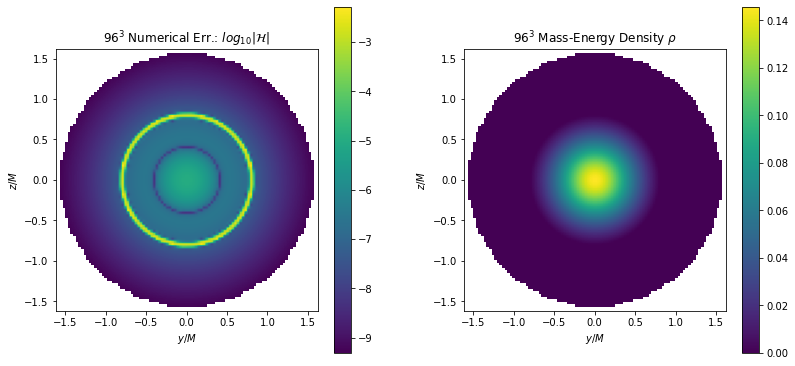

In [16]:
fig = plt.figure(figsize=(12, 6))

axN = []  # initialize axis/plot array.


Labels = [r"$96^3$ Numerical Err.: $log_{10}|\mathcal{H}|$",
          r"$96^3$ Mass-Energy Density $\rho$"]

for whichplot in range(2):
    #Generate the subplot for the each constraint
    ax = fig.add_subplot(121 + whichplot)
    axN.append(ax) # Grid of 2x1

    axN[whichplot].set_xlabel(r'$y/M$')
    axN[whichplot].set_ylabel(r'$z/M$')
    axN[whichplot].set_title(Labels[whichplot])

    figure = plt.imshow(output_grid_data[whichplot], extent=(-xy_extent,xy_extent, -xy_extent,xy_extent))
    cb = plt.colorbar(figure)

# Adjust the spacing between plots
plt.tight_layout(pad=4)

<a id='convergence'></a>

# Step 7: Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero \[Back to [top](#toc)\]
$$\label{convergence}$$

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

Next, we set up the same initial data but on a lower-resolution, $48\times 8\times 2$ grid (axisymmetric in the $\phi$ direction). Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96\times 16\times 2$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected, *except* at the star's surface where the stress-energy tensor $T^{\mu\nu}$ sharply drops to zero.

<Figure size 432x288 with 0 Axes>

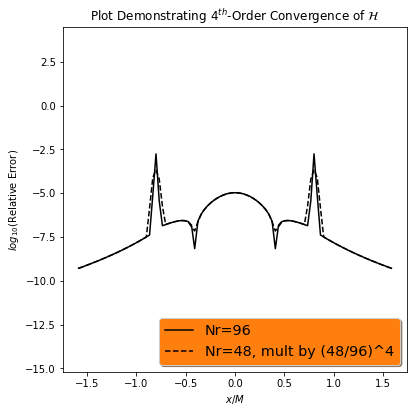

In [17]:
# Plot settings
x_extent=domain_size      # plot from -x_extent to +x_extent
sample_numpts_x = 100     # number of points to plot
interp_method = "linear"  # Could be linear (recommended), nearest (don't use; gridpoints are off-axis), or cubic

# Data are in format x,y,z, CF,Ham,rho
output_1D_grid_data48 = []
output_1D_grid_data96 = []
for i in [4]:  # H constraint is in column 4 (where x is stored in the 0th column)
    output_grid_x96, output_1D_grid_data48_i = \
        plot2D.extract_1D_slice_from_2D_data('out48.txt', 0.0,
                                      1,2,i, [-x_extent, x_extent], sample_numpts_x=sample_numpts_x,
                                      interp_method=interp_method)
    output_grid_x48, output_1D_grid_data96_i = \
        plot2D.extract_1D_slice_from_2D_data('out96.txt', 0.0,
                                      1,2,i, [-x_extent, x_extent], sample_numpts_x=sample_numpts_x,
                                      interp_method=interp_method)
    output_1D_grid_data48 += [output_1D_grid_data48_i]
    output_1D_grid_data96 += [output_1D_grid_data96_i]


PlotTitles=[r"\mathcal{H}"]

axN = []
plt.clf()

# We want to create four plots. One for the Hamiltonian, and three for the momentum
# constrains (r,th,ph)
# Define the size of the overall figure
fig = plt.figure(figsize=(12,12))

for p in range(1): #loop to cycle through our constraints and plot the data
    #Generate the subplot for the each constraint
    ax = fig.add_subplot(221+p)
    axN.append(ax) # Grid of 2x2
    axN[p].set_title('Plot Demonstrating $4^{th}$-Order Convergence of $'+PlotTitles[p]+'$')
    axN[p].set_xlabel(r"$x/M$")
    axN[p].set_ylabel("$log_{10}$(Relative Error)")

    ax.plot(output_grid_x96, output_1D_grid_data96[p], 'k-', label='Nr=96')
    ax.plot(output_grid_x48, output_1D_grid_data48[p] + 4*np.log10(48./96.), 'k--', label='Nr=48, mult by (48/96)^4')
    ax.set_ylim([-15.2,4.5])

    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('C1')

# Adjust the spacing between plots
plt.tight_layout(pad=4)

<a id='latex_pdf_output'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [18]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data")

[NbConvertApp] WARNING | pattern 'Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb' matched no files
Created Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_TOV_initial_data.tex, and compiled LaTeX file to PDF file
    Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_TOV_initial_data.pdf
